In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import dates
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from  sklearn.metrics import  mean_absolute_error,mean_squared_error
from statsmodels.tsa.ar_model import  AutoReg , ar_select_order
from statsmodels.tsa.stattools import adfuller
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoins/BTC-USD.csv


In [2]:
btc=pd.read_csv('/kaggle/input/bitcoins/BTC-USD.csv')
btc['Date'] = btc['Date'].astype('datetime64[ns]')
btc.set_index('Date', inplace=True)
btc['Adj_Close'] =btc['Adj Close']
btc.head()

,Open,High,Low,Close,Adj Close,Volume,Adj_Close
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,398.821014


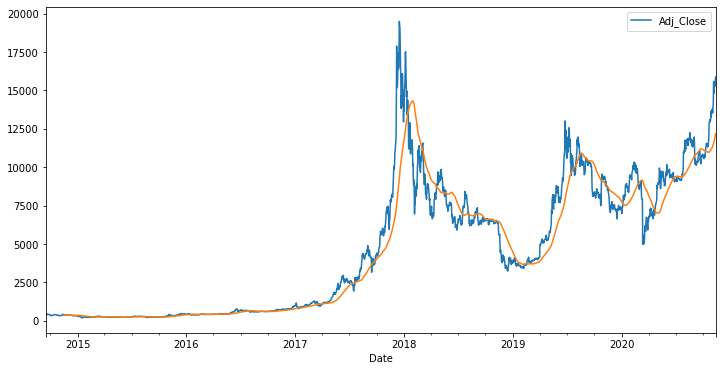

In [3]:
btc.drop(btc.columns.difference(['Adj_Close']),1,inplace=True)
btc.plot(figsize=(12,6))
btc.rolling(window=60).mean()['Adj_Close'].plot()

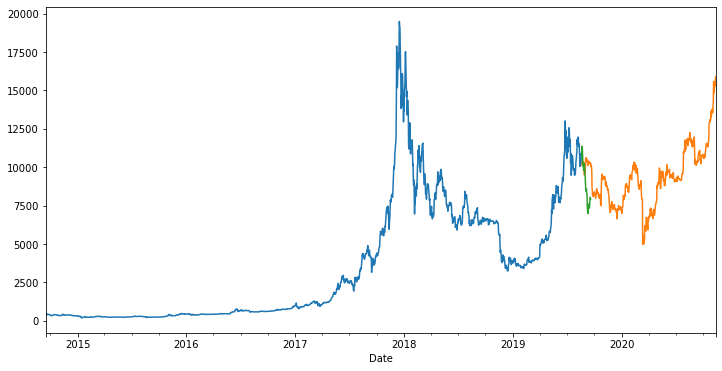

In [4]:
btc=btc.asfreq('D')
train_btc=btc.iloc[:1799]
test_btc=btc.iloc[1799:]
fit_model=ExponentialSmoothing(train_btc['Adj_Close'],trend='mul',seasonal='mul',seasonal_periods=450).fit()
prediction=fit_model.forecast(30)
train_btc['Adj_Close'].plot(figsize=(12,6))
test_btc['Adj_Close'].plot()
prediction.plot()

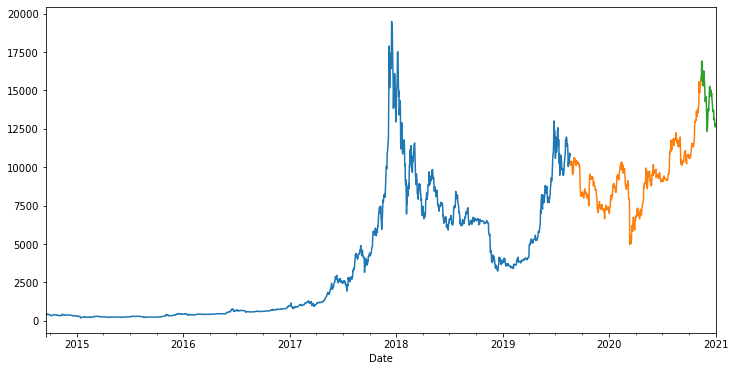

In [5]:
fit_model=ExponentialSmoothing(btc['Adj_Close'],trend='mul',seasonal='mul',seasonal_periods=450).fit()
prediction=fit_model.forecast(50)
train_btc['Adj_Close'].plot(figsize=(12,6))
test_btc['Adj_Close'].plot()
prediction.plot()

In [6]:
#pd.plotting.register_matplotlib_converters()
#btc=btc.asfreq('D')
#model= AutoReg(btc['Adj_Close'],300)
#model_fit=model.fit()
#train_btc=btc.iloc[:1799]
#test_btc=btc.iloc[1799:]
#train_model=AutoReg(train_btc['Adj_Close'],320).fit(cov_type='HC0')
#start= len(train_btc)
#end=len(train_btc) + len(test_btc) - 1 
#prediction = train_model.predict(start=start , end=end, dynamic=True)
#fig,ax=plt.subplots()
#ax = test_btc.plot(ax=ax)
#ax = prediction.plot(ax=ax)

In [7]:
#forecast = train_model.predict(start=end , end=end+60, dynamic=True)
#btc.isnull().values.any()
#ax= forecast.plot(ax=ax)

#mask= (btc.index > '2018-01-01')   &  (btc.index < '2020-11-01)
#df2=btc.loc[mask]

In [8]:
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)
    adf_test(btc)

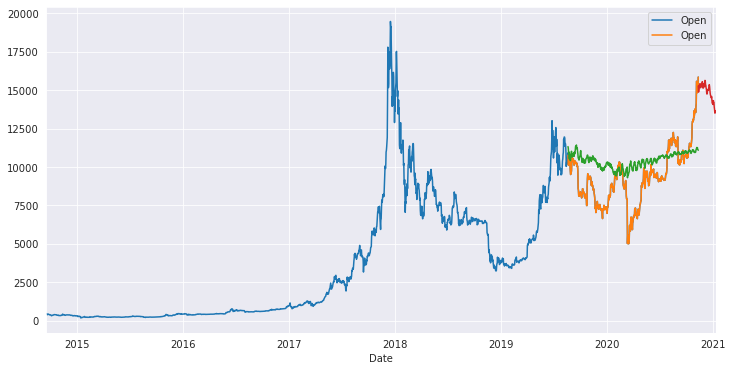

In [9]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

df1 = pd.read_csv('/kaggle/input/bitcoins/BTC-USD.csv', index_col='Date', parse_dates=True)
df1.drop(df1.columns.difference(['Open']),1,inplace=True)
df1 = df1.asfreq('d') # Change frequency to day
df1 = df1.fillna(method='ffill')
df1.index # Check frequency
df1.isnull().values.any() # Check for NaNs

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot daily max temps
fig, ax = plt.subplots()
ax = df1.plot(ax=ax)

# Create our model using whole data set
model = AutoReg(df1['Open'], 300)
model_fit = model.fit()

# Define training and testing area
len(df1) # 345 observations
train_df = df1.iloc[:1799] # 80%
test_df = df1.iloc[1799:] # Last 20%

# Define training model for 100 days and White's covariance
# estimator
train_model = AutoReg(df1['Open'], 320).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+60, dynamic=True)
ax = forecast.plot(ax=ax) # Red

In [10]:
#pip install pmdarima
from pmdarima import auto_arima
btc.drop(btc.columns.difference(['Adj_Close']),1,inplace=True)
btc=btc.asfreq('MS')
step_fit=auto_arima(btc['Adj_Close'],start_p=0,start_q=0,max_p=5,max_q=3,seasonal=True,trace=True,m=12)
step_fit.summary()

ModuleNotFoundError: No module named 'pmdarima'

In [11]:
from statsmodels.tsa.arima_model import ARIMA , ARMA ,ARIMAResults, ARMAResults
from statsmodels.graphics.tsaplots import  plot_acf , plot_pacf
#pip install pmdarima
#ARIMAX(0, 1, 0)
btc.drop(btc.columns.difference(['Adj_Close']),1,inplace=True)
btc=btc.asfreq('MS')
train_btc=btc.iloc[:59]
test_btc=btc.iloc[59:]
mod=ARIMA(train_df,order=(0, 1, 0))
res=mod.fit()
res.summary()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction=res.predict(end,end+12) #start , end
btc.plot(figsize=(8,8),legend=True)
prediction.plot(legend=True)

ValueError: Length of passed values is 462, index implies 13.

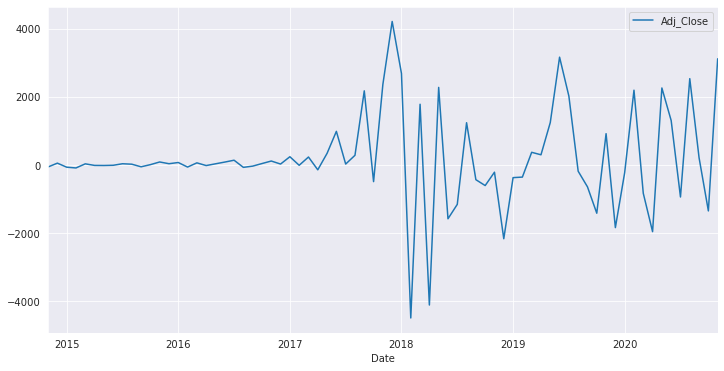

In [12]:
diff_df=btc.diff().dropna()
diff_df.plot()

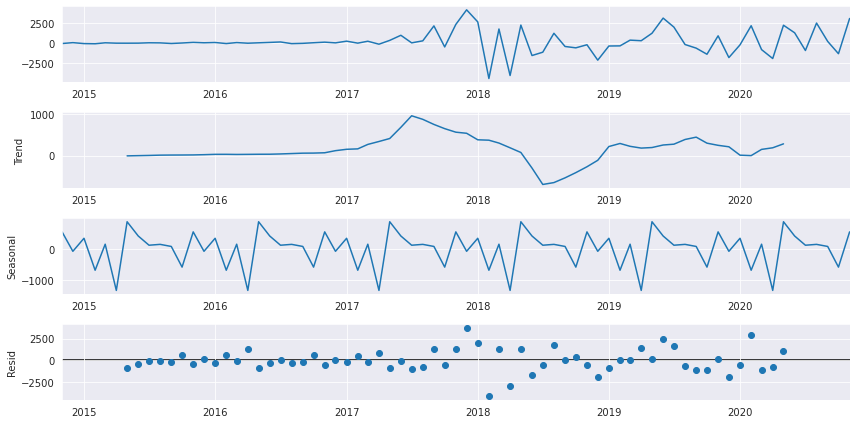

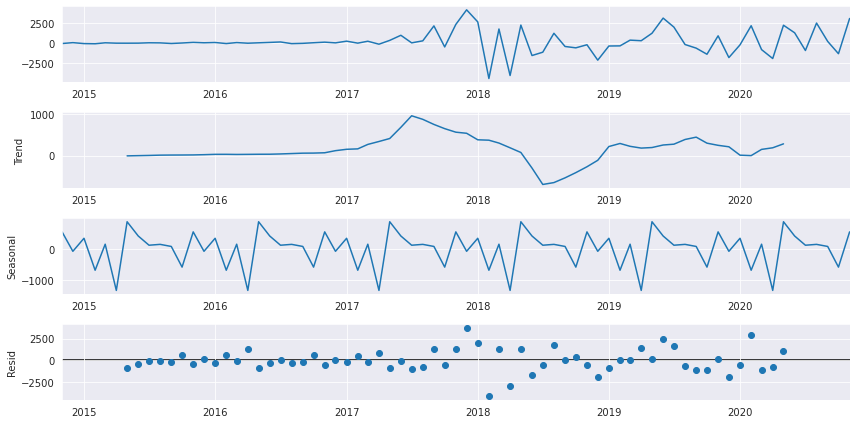

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
res=seasonal_decompose(diff_df,model='add')
res.plot()

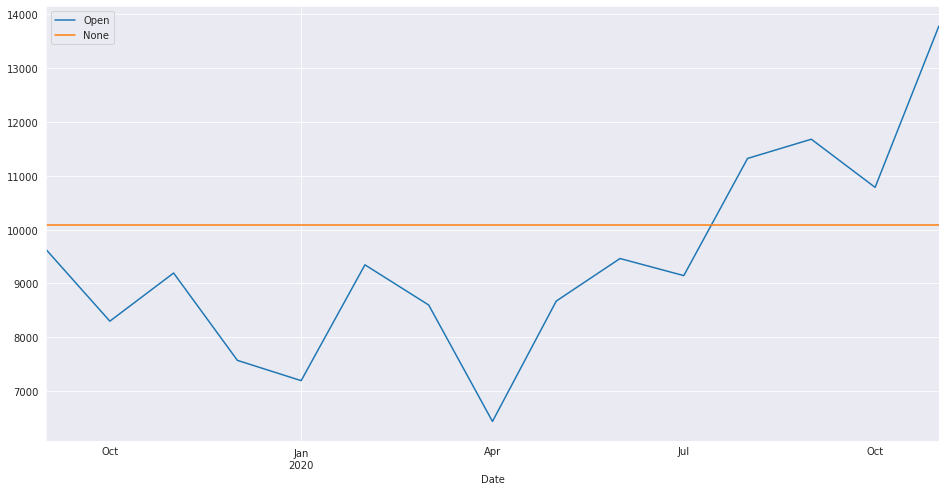

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df1 = pd.read_csv('/kaggle/input/bitcoins/BTC-USD.csv', index_col='Date', parse_dates=True)
df1.drop(df1.columns.difference(['Open']),1,inplace=True)
df1 = df1.asfreq('MS') # Change frequency to day
df1 = df1.fillna(method='ffill')
df1.index # Check frequency
df1.isnull().values.any() # Check for NaNs
train_df = df1.iloc[:59] #1799 FOR DAYS
test_df = df1.iloc[59:] 
model=SARIMAX(train_df,order=(0, 1, 0))
res=model.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1
prediction=res.predict(start,end,typ='linear')
test_df.plot(legend=True,figsize=(16,8))
prediction.plot(legend=True)

FUTURE

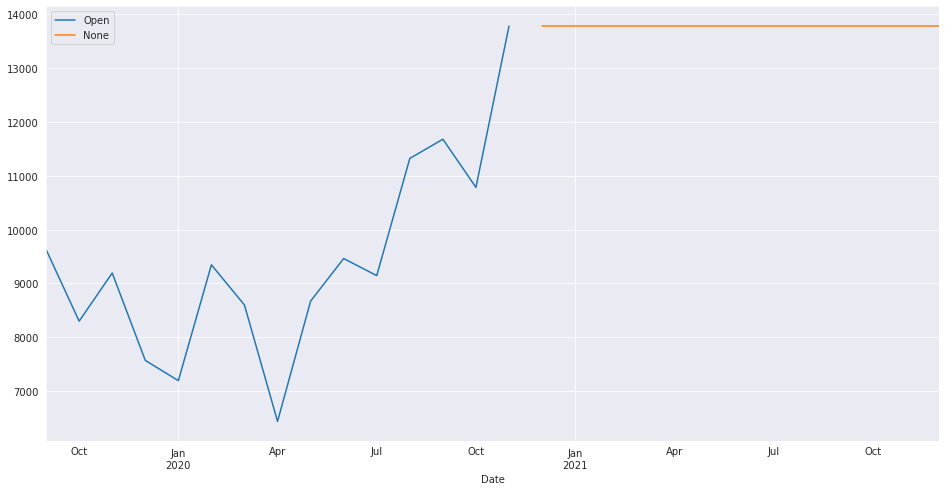

In [15]:
model=SARIMAX(df1,order=(0, 1, 0))
res=model.fit()
future=res.predict(len(df1),len(df1)+12)
test_df.plot(legend=True,figsize=(16,8))
future.plot(legend=True)

VERSION 2

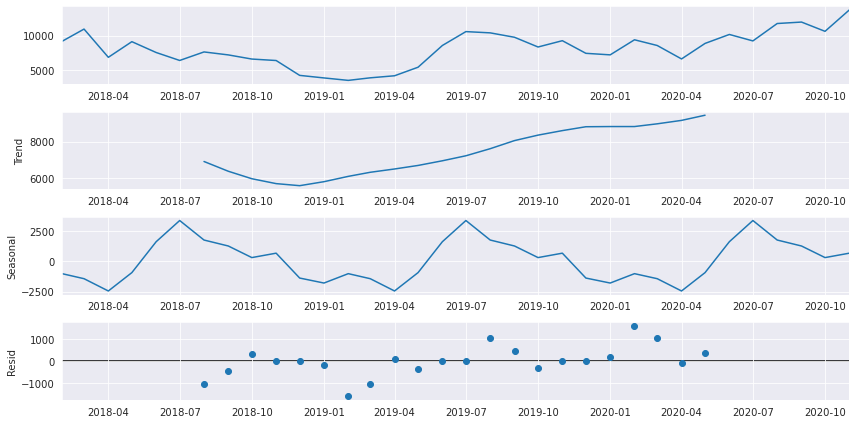

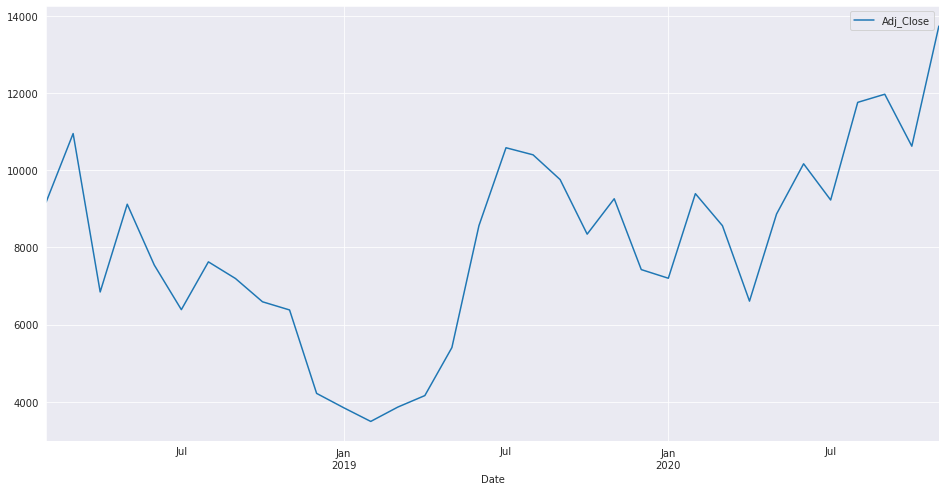

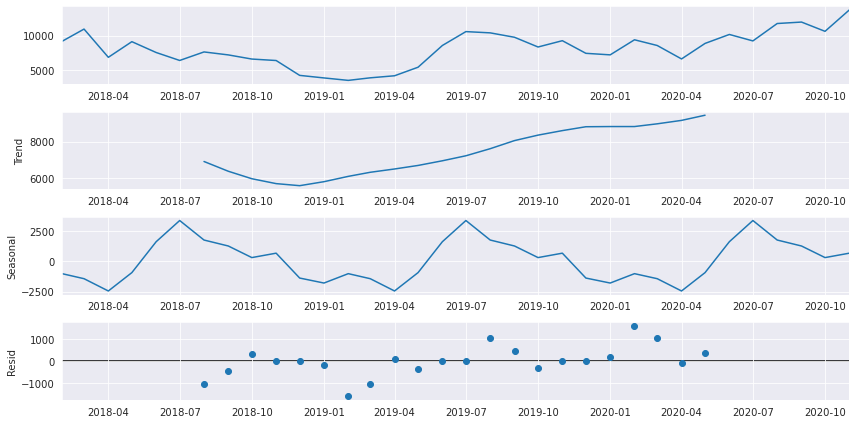

In [16]:

# Monthly global CO2 data since 1960
btc = btc[btc.index>'2018-01-01']
btc = btc.asfreq('MS') # Change frequency to month
btc = btc.fillna(method='ffill')
btc.plot(figsize=(16,8))

# We verify that there is a seasonal component
res = seasonal_decompose(btc, model='add')
res.plot()

In [17]:
auto_arima(btc, seasonal=True, m=12, trace=True).summary()

NameError: name 'auto_arima' is not defined

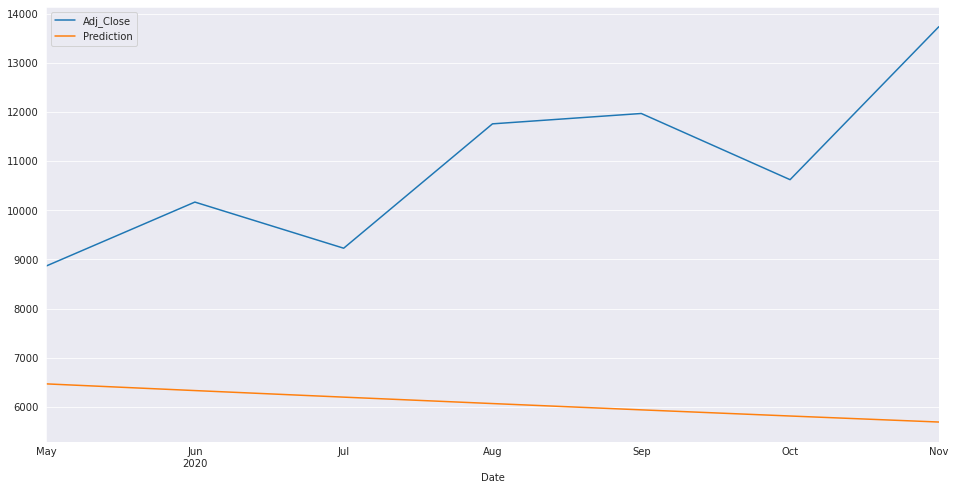

In [18]:
len(btc) # 34

train_df = btc.iloc[:27] # 80%
test_df = btc.iloc[27:] # 20%

# Parameters include the dataset, the 1st order for ARIMA, ARIMA(0,1,0)(0,0,0)[24]
# the seasonal order
model = SARIMAX(train_df, order=(1, 0, 0),
               seasonal_order=(0, 0, 0, 12))
res = model.fit()
# Get prediction for test set
start = len(train_df)
end = len(train_df) + len(test_df) - 1
# type typ : levels - Predict original endogenous variables
# linear : Linear prediction
prediction = res.predict(start, end, 
                         typ='linear').rename('Prediction')
test_df.plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

future

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


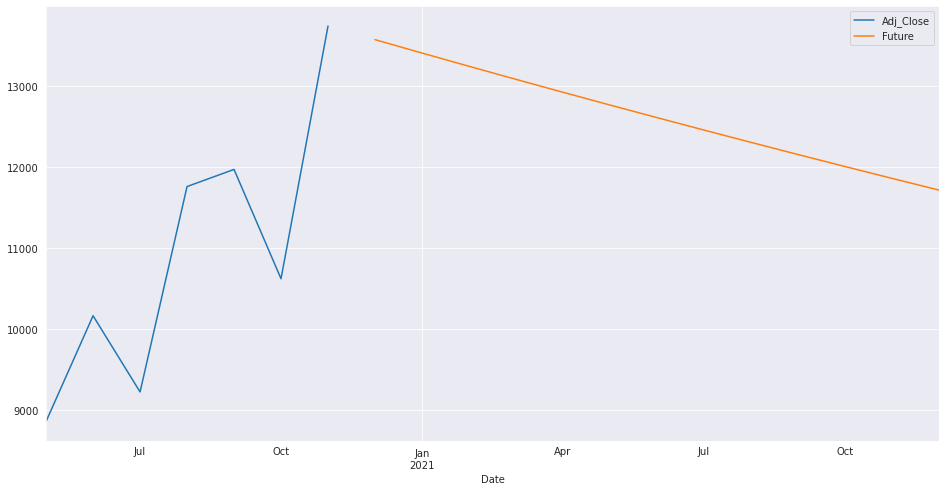

In [19]:
model = SARIMAX(btc, order=(1, 0, 0),
               seasonal_order=(0, 0, 0, 12))
res = model.fit()
future = res.predict(len(btc), len(btc)+12, 
                    typ='levels').rename('Future')
test_df.plot(legend=True, figsize=(16,8))
future.plot(legend=True)

In [20]:
#color_arr = ['g', 'r', 'm', 'b', 'y', 'k']
#c_indx = 0
#for x in oil_df[oil_df['holiday']==1].index:
  #  ax.axvline(x=x, color=color_arr[c_indx], linewidth=0.5);
  #  if color_arr[c_indx] == 'k':
  #      c_indx = 0
   # else:
   #     c_indx += 1

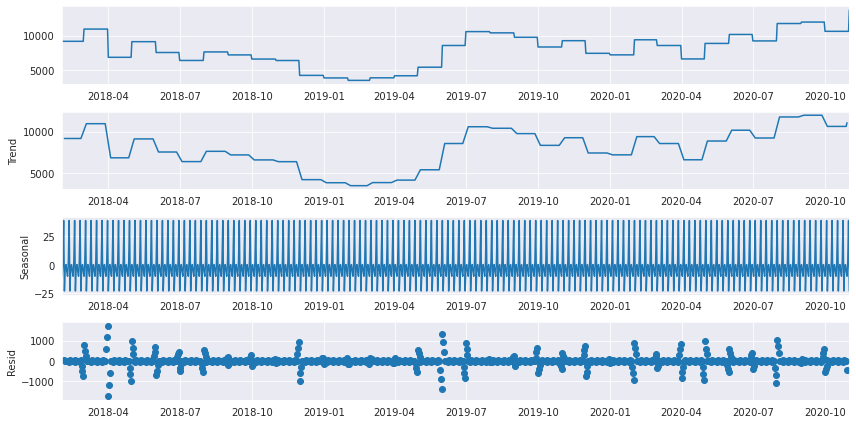

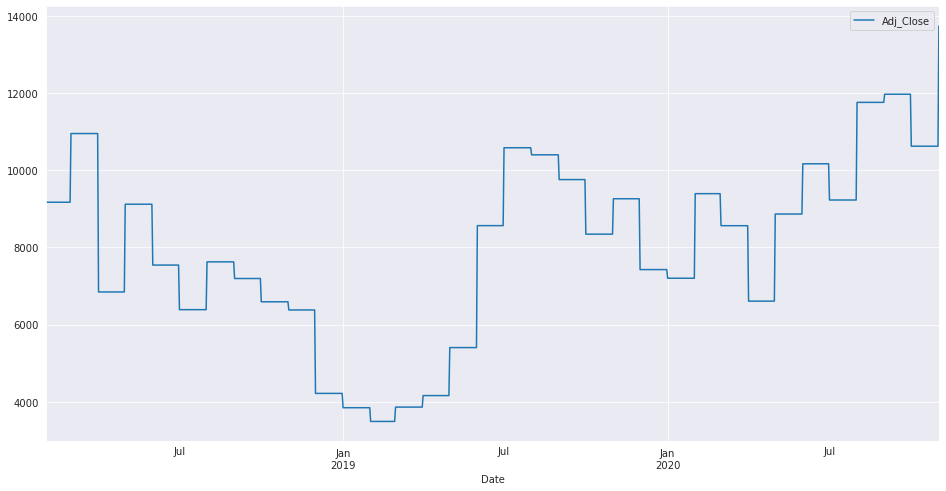

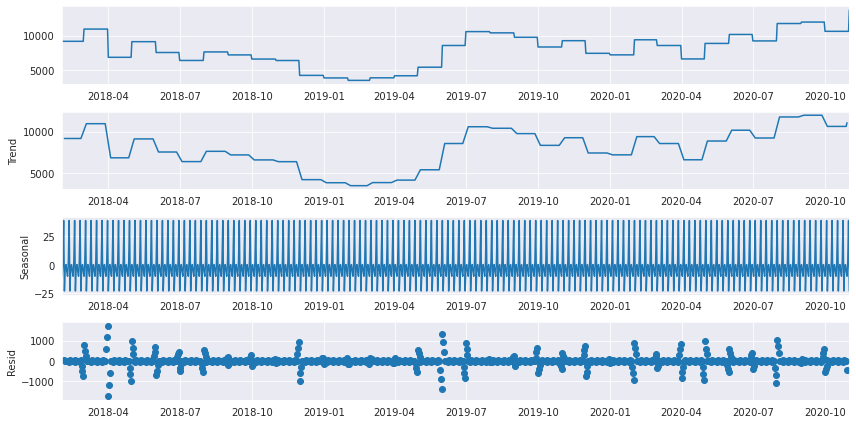

In [21]:
btc = btc[btc.index>'2017-01-01']
btc = btc.asfreq('D') # Change frequency to month
btc = btc.fillna(method='ffill')
btc.plot(figsize=(16,8))

# We verify that there is a seasonal component
res = seasonal_decompose(btc, model='add')
res.plot()

In [22]:
auto_arima(btc, seasonal=True, m=180, trace=True).summary()

NameError: name 'auto_arima' is not defined

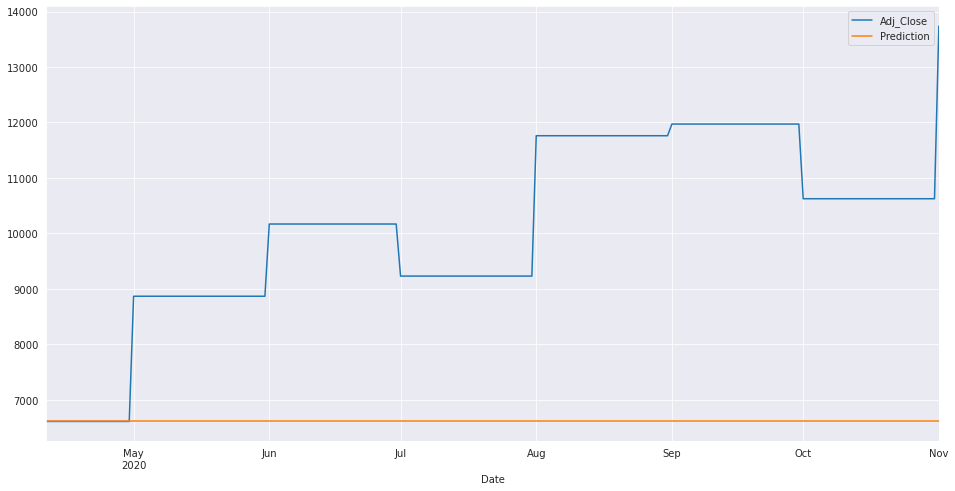

In [23]:
len(btc) # 1005

train_df = btc.iloc[:800] # 80%
test_df = btc.iloc[800:] # 20%

# Parameters include the dataset, the 1st order for ARIMA, ARIMA(0,1,0)(0,0,0)[24]
# the seasonal order
model = SARIMAX(train_df, order=(0, 1, 0),
               seasonal_order=(0, 0, 0, 180))
res = model.fit()
# Get prediction for test set
start = len(train_df)
end = len(train_df) + len(test_df) - 1
# type typ : levels - Predict original endogenous variables
# linear : Linear prediction
prediction = res.predict(start, end, 
                         typ='linear').rename('Prediction')
test_df.plot(legend=True, figsize=(16,8))
prediction.plot(legend=True)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


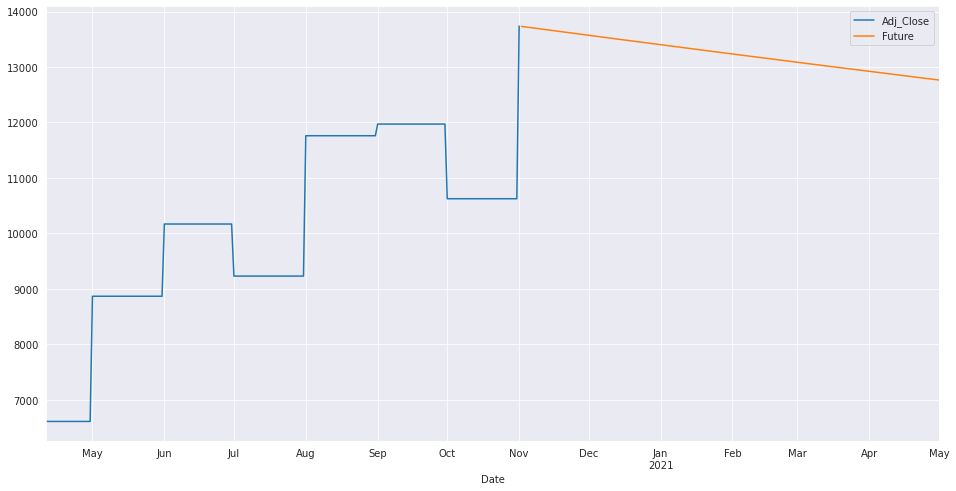

In [24]:
model = SARIMAX(btc, order=(1, 0, 0),
               seasonal_order=(0, 0, 0, 180))
res = model.fit()
future = res.predict(len(btc), len(btc)+180, 
                    typ='levels').rename('Future')
test_df.plot(legend=True, figsize=(16,8))
future.plot(legend=True)

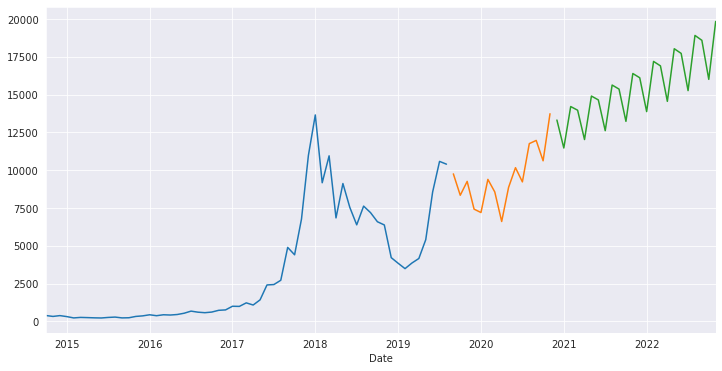

In [25]:
btc=btc.asfreq('MS')
btc = btc[btc.index>'2017-01-01']
len(btc) # 46
train_df = btc.iloc[:36] # 80%
test_df = btc.iloc[36:] # 20%
fit_model=ExponentialSmoothing(train_df['Adj_Close'],trend='mul',seasonal='mul',seasonal_periods=3).fit()
prediction=fit_model.forecast(24)
train_btc['Adj_Close'].plot(figsize=(12,6))
test_btc['Adj_Close'].plot()
prediction.plot()

ValueError: zero-size array to reduction operation fmin which has no identity

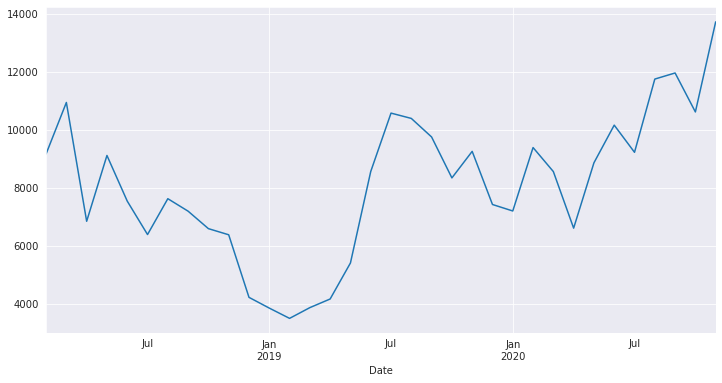

In [26]:
fit_model=ExponentialSmoothing(btc['Adj_Close'],trend='mul',seasonal='mul',seasonal_periods=9).fit()
prediction=fit_model.forecast(12)
train_df['Adj_Close'].plot(figsize=(12,6))
test_df['Adj_Close'].plot()
prediction.plot()